### 1. Imports & Setup

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 2. Data Folder & Class List

In [2]:
data_dir = "../data/train"
labels = ["NORMAL", "PNEUMONIA"]

### 3. Class Distribution

Class counts: {'NORMAL': 1300, 'PNEUMONIA': 2327}


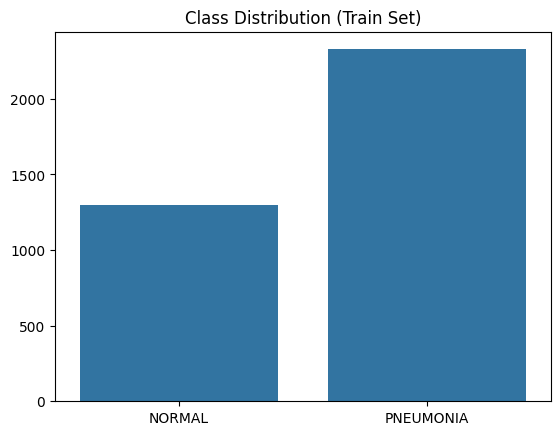

In [3]:
counts = {label: len(os.listdir(os.path.join(data_dir, label))) for label in labels}
print("Class counts:", counts)
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Class Distribution (Train Set)")
plt.show()

### 4. Sample Images Display

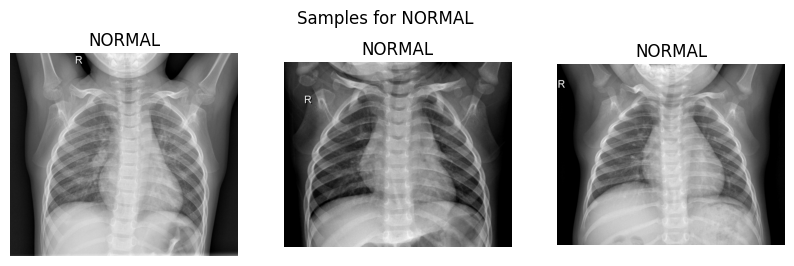

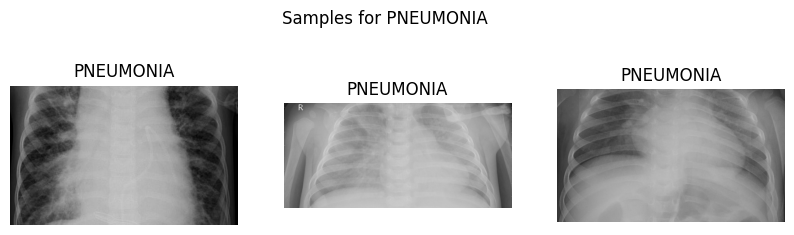

In [4]:
for label in labels:
    sample_imgs = os.listdir(os.path.join(data_dir, label))[:3]
    plt.figure(figsize=(10,3))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(data_dir, label, img_name)
        img = Image.open(img_path)
        plt.subplot(1,3,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.suptitle(f"Samples for {label}")
    plt.show()

### 5. Image Shape & Aspect Ratio Checks

Image shape stats (first 100):


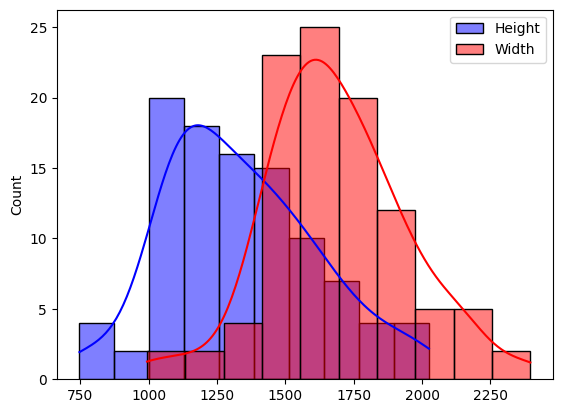

In [5]:
img_paths = [os.path.join(data_dir, label, fname) for label in labels for fname in os.listdir(os.path.join(data_dir, label))]
shapes = [cv2.imread(img_path).shape for img_path in img_paths[:100] if cv2.imread(img_path) is not None]
print("Image shape stats (first 100):")
sns.histplot([s[0] for s in shapes], bins=10, kde=True, color="blue", label="Height")
sns.histplot([s[1] for s in shapes], bins=10, kde=True, color="red", label="Width")
plt.legend()
plt.show()

### 6. Pixel Intensity Histogram

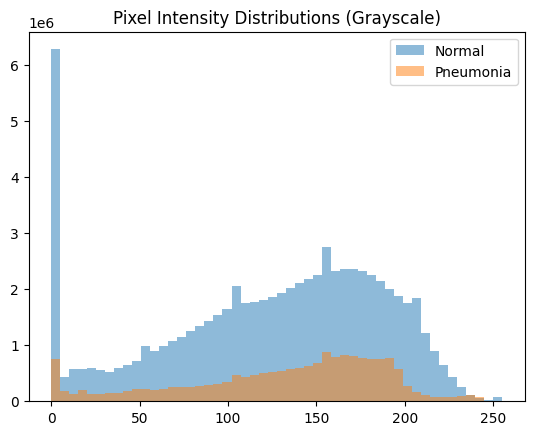

In [6]:
def load_grayscale_imgs(image_dir, count=30):
    images = []
    for fname in os.listdir(image_dir)[:count]:
        img_path = os.path.join(image_dir, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

normal_dir = os.path.join(data_dir, "NORMAL")
pneumonia_dir = os.path.join(data_dir, "PNEUMONIA")
normal_imgs = load_grayscale_imgs(normal_dir)
pneumonia_imgs = load_grayscale_imgs(pneumonia_dir)
plt.hist(np.concatenate([img.ravel() for img in normal_imgs]), bins=50, alpha=0.5, label='Normal')
plt.hist(np.concatenate([img.ravel() for img in pneumonia_imgs]), bins=50, alpha=0.5, label='Pneumonia')
plt.legend()
plt.title("Pixel Intensity Distributions (Grayscale)")
plt.show()

### 7. Image Augmentation Demo

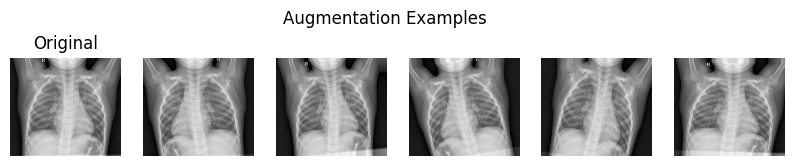

In [7]:
img = normal_imgs[0]
if img.ndim == 2:
    img = np.stack([img]*3, axis=-1)
elif img.shape[-1] == 1:
    img = np.concatenate([img]*3, axis=-1)
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.1, horizontal_flip=True)
plt.figure(figsize=(10,2))
plt.subplot(1,6,1)
plt.imshow(img.astype('uint8'))
plt.axis('off')
plt.title("Original")
for i, batch in enumerate(datagen.flow(img.reshape(1,*img.shape), batch_size=1)):
    plt.subplot(1,6,i+2)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    if i == 4: break
plt.suptitle("Augmentation Examples")
plt.show()

### 8. Train/Test Split for Analysis

In [8]:
def resize_imgs(img_list, target_size=(64, 64)):
    resized = []
    for img in img_list:
        if img.shape != target_size:
            resized.append(cv2.resize(img, target_size))
        else:
            resized.append(img)
    return resized

# Resize both classes
normal_imgs_resized = resize_imgs(normal_imgs, target_size=(64,64))
pneumonia_imgs_resized = resize_imgs(pneumonia_imgs, target_size=(64,64))

# Now flatten
normal_flat = [img.ravel() for img in normal_imgs_resized[:20]]
pneumonia_flat = [img.ravel() for img in pneumonia_imgs_resized[:20]]
X = np.array(normal_flat + pneumonia_flat)
y = np.array([0]*20 + [1]*20)

### 9. PCA Visualization

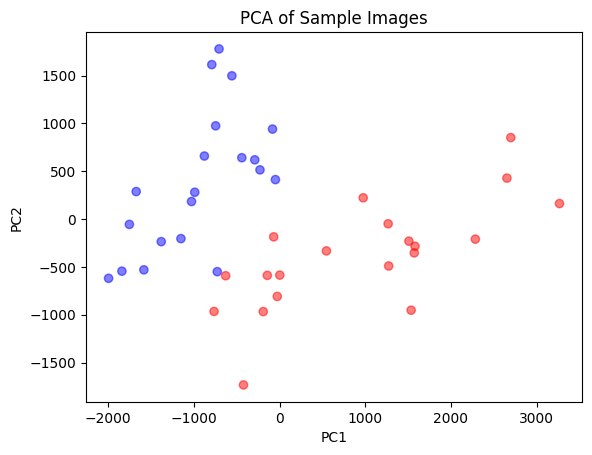

In [9]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X)
plt.scatter(proj[:,0], proj[:,1], c=y, cmap='bwr', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Sample Images")
plt.show()

### 10. Outlier Detection

Outlier images found: 1140


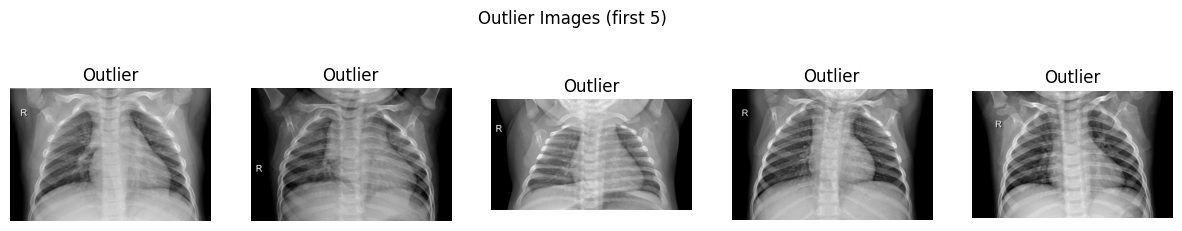

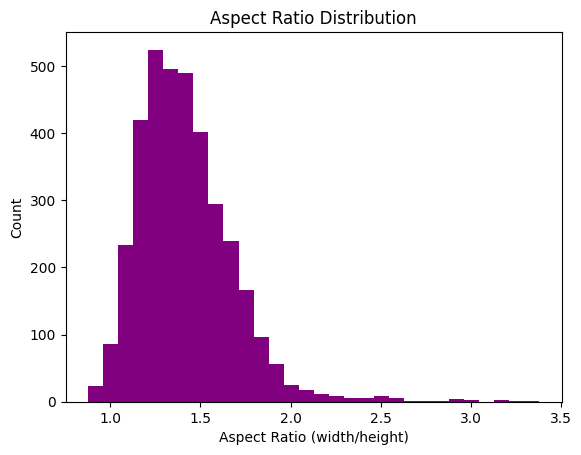

In [10]:
min_dim = 150
outlier_files = []
aspect_ratios = []
for label in labels:
    for fname in os.listdir(os.path.join(data_dir, label)):
        img_path = os.path.join(data_dir, label, fname)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            aspect_ratios.append(w / h)
            if min(h,w) < min_dim or abs(w/h - 1) > 0.5:
                outlier_files.append(img_path)
print(f"Outlier images found: {len(outlier_files)}")
if outlier_files:
    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(outlier_files[:5]):
        img = cv2.imread(img_path)
        plt.subplot(1,5,i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Outlier")
        plt.axis('off')
    plt.suptitle("Outlier Images (first 5)")
    plt.show()
plt.hist(aspect_ratios, bins=30, color='purple')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (width/height)")
plt.ylabel("Count")
plt.show()


## Insights
- The dataset is imbalanced (see bar chart), consider class weighting or augmentation in training.
- Image sizes and pixel distributions are diverse; resizing and normalization will be key for model.
- Example images and augmentation demonstrate X-ray variety and pipeline capability.
- PCA shows class separation, but labels overlap in raw pixel space.

## Next Steps
- Advanced augmentation (brightness, CLAHE).
- Train/test/eval split for cross-validation.
- Grad-CAM visualizations after model training.
- Add clinical insights/disclaimer: For educational use only, not clinical deployment.
